# Data Challenge: Sentiment Analysis

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai import *

# Important Notes for readers!
This notebook is not meant to be a reproducable file for the submitted model. Running this notebook from top to bottom will not lead to anything. Therefore, I would recommended to run each cell only if you understand what it is doing.

## ------------------------------
## 0. Setup
## 1. Preparing Date
## 2. Language Model
## 3. Classification Model
## 4. Test set
## ------------------------------

## 0. Setup

I used Google Cloud Platform as my environment where I runned a virtual machine predefined with fastai setup (PyTorch 1.0.0 and fastai 1.0.2)
https://course.fast.ai/start_gcp.html

## 1. Preparing the data

In [3]:
path = Config.data_path()/'solvay'
path.ls()

[PosixPath('/home/jupyter/.fastai/data/solvay/FastAi_results.json'),
 PosixPath('/home/jupyter/.fastai/data/solvay/FastAi_model.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/test_set_no_score_26-2-2019.csv'),
 PosixPath('/home/jupyter/.fastai/data/solvay/data_clas.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/data_lm2.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/FastAi_results_tosubmit.json'),
 PosixPath('/home/jupyter/.fastai/data/solvay/df_lm.csv'),
 PosixPath('/home/jupyter/.fastai/data/solvay/training_set_26-2-2019.csv'),
 PosixPath('/home/jupyter/.fastai/data/solvay/data_lm_all.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/data_lm.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/models'),
 PosixPath('/home/jupyter/.fastai/data/solvay/training_set_26-2-2019.json'),
 PosixPath('/home/jupyter/.fastai/data/solvay/test_set_no_score_26-2-2019.json'),
 PosixPath('/home/jupyter/.fastai/data/solvay/tmp')]

### 1.1. From JSON to csv

It contains the json file with reviews, let's have a look at it. 

In [4]:
df_to_csv = pd.read_json(path/'training_set_26-2-2019.json')

In [5]:
df_test_to_csv =  pd.read_json(path/'test_set_no_score_26-2-2019.json')

In [6]:
df_to_csv.head()

,_id,text
0,5c6d03c268869913683e7e1a,I really prefer the Shoumei Green Tea which is...
1,5c6d03c268869913683e7e4c,"I have liked other Hot Pockets, like the ham a..."
2,5c6d03c268869913683e7e50,This carafe was initially perfect. The design...
3,5c6d03c268869913683e7e62,I bought this to give my love life some spice....
4,5c6d03c268869913683e7e89,"This milk is advertised as ""vanilla"" milk. But..."


In [6]:
df_to_csv['text'][1]

"Cellulose Gel, Lactic Acid, Sucralose, Titanium Dioxide, Salt, Xanthan Gum, and Potassium Sorbate.....yum can't wait to get me some more titanium dioxide in me...how great does that sound!"

The classification model will require a train & valid set, so we split randomnly 80% of the dataset to train, remaining 20% to valid. Then concatenate them, and reorder the columns

In [7]:
# Split randomly
train_df = df_to_csv.sample(frac=0.8)
train_df['is_valid'] = 0

valid_df = df_to_csv.drop(train_df.index)
valid_df['is_valid'] = 1

# Concatenate
df_to_csv = pd.concat([train_df, valid_df])

# Order columns
df_to_csv = df_to_csv[['score_01', 'text', 'is_valid', '_id']]

In [10]:
df_to_csv.head()

,score_01,text,is_valid,_id
28008,0,"Some decent stuff, but he barely mentions ETFs...",0,5c6d049168869913684a5817
78777,0,This movie is so bad that it actually gets fun...,0,5c6e991e68869904caaa2da6
20316,1,This book by Dave Pelzer was by far the best b...,0,5c6d0454688699136846e82d
39511,0,"Even as a kid, I remember getting bored with P...",0,5c6d04e368869913684fa1d4
16542,1,I am somewhat amused by some of the other revi...,0,5c6d0435688699136845473d


In [7]:
# check for total null value
df_to_csv.isnull().sum().sum()

0

In [14]:
df_to_csv.loc[df_to_csv['_id'] == '5c6d041a688699136843ad79']

,score_01,text,is_valid,_id
12777,0,,0,5c6d041a688699136843ad79


In [8]:
# Export the data frame to csv
df_to_csv.to_csv(path/'training_set_26-2-2019.csv', index = False)

### 1.2. Inspect csv file (verify the format)

In [18]:
df = pd.read_csv(path/'training_set_26-2-2019.csv')

In [9]:
df_test = pd.read_csv(path/'test_set_no_score_26-2-2019.csv')

In [16]:
df.head()

,_id,text
0,5c6d03c268869913683e7e1a,I really prefer the Shoumei Green Tea which is...
1,5c6d03c268869913683e7e4c,"I have liked other Hot Pockets, like the ham a..."
2,5c6d03c268869913683e7e50,This carafe was initially perfect. The design...
3,5c6d03c268869913683e7e62,I bought this to give my love life some spice....
4,5c6d03c268869913683e7e89,"This milk is advertised as ""vanilla"" milk. But..."


In [15]:
# Text has some Null
df.isnull().any() 

_id     False
text    False
dtype: bool

the first time you run it, there will be some missing data in text (empty string). We will identify which rows contain NaN(null).

In [14]:
df['text'].isnull().sum()

0

In [20]:
(df['text'].isnull() * df['score_01']).sum()

183

### 1.3. Missing Value (missing text)

Out of the 291 text data missing, 183 (62.9%) was associated with a positive score (score = 1). This might suggest that people are slightly more likely to skip the text review when the feedback is positive, than when the feednack is negative. We will keep these data since it is a valuable information. We will therefore assign a blank space instead of NaN.

In [13]:
# df['text'].isnull()
df['text'] = np.where(df['text'].isnull(), ' ', df['text'])

In [22]:
# check on the same row where we had NaN before
df.loc[df['_id'] == '5c6d041a688699136843ad79']

,score_01,text,is_valid,_id
46320,0,,0,5c6d041a688699136843ad79


In [23]:
# Export 
df.to_csv(path/'training_set_26-2-2019.csv', index = False)

In [17]:
# Export 
df_test.to_csv(path/'test_set_no_score_26-2-2019.csv', index = False)

We can confirm that the value of text is no longer NaN. 

### 1.4. Eliminate labels for the language model (test)

`df_lm` will be used for the language model, therefore all label (`score_01`) are set to 0. (required in fastai API).
We are going to use the whole dataset (train, validation and TEST SET) for the language model since we don't get the model to learn classification. The language model will be trained to predict the next word in the sentence.

In [25]:
# copy from df created above
df_lm = df

In [23]:
# reorder column for test set
df_test = df_test[['text', '_id']]

In [29]:
# Concatenate test and train, val set
df_lm = pd.concat([df.drop(['_id', 'is_valid'], axis=1), df_test.drop(['_id'], axis=1)], sort=False)

In [10]:
# set all label to 0. (required in fastai)
df_lm['score_01'] = 0

NameError: name 'df_lm' is not defined

In [31]:
# drop unnecessary columns
df_lm = df_lm.drop(['_id', 'is_valid'], axis=1)

KeyError: "['_id' 'is_valid'] not found in axis"

In [32]:
df_lm

,score_01,text
0,0,"Some decent stuff, but he barely mentions ETFs..."
1,0,This movie is so bad that it actually gets fun...
2,0,This book by Dave Pelzer was by far the best b...
3,0,"Even as a kid, I remember getting bored with P..."
4,0,I am somewhat amused by some of the other revi...
5,0,There are exactly 2 good things to be said abo...
6,0,Ever once in a while I run into a movie that i...
7,0,During an eight-year stretch of the 1980s when...
8,0,Weinschenk at #bankinnovation: next battle for...
9,0,this is really films outside (not in a motel r...


In [33]:
# Export as csv file
df_lm.to_csv(path/'df_lm.csv', index = False)

We now create a DataBunch (TextDataBunch): see https://docs.fast.ai/text.data.html#Factory-methods-(TextDataBunch)


In [34]:
data_lm = TextLMDataBunch.from_csv(Path(path), 'df_lm.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [35]:
data_lm.save('data_lm_all.pkl')

Next time we launch this notebook, we can skip the cell above that took a bit of time and load those results like this:

In [5]:
data_lm = load_data(path, 'data_lm_all.pkl')

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [27]:
data = TextClasDataBunch.from_csv(path,  'training_set_26-2-2019.csv')
data.show_batch()

text,target
"xxbos xxmaj there 's a sign on xxmaj the xxmaj lost xxmaj highway that xxunk xxup spoilers xxunk you already knew that , did n't xxunk there 's a great deal of people that apparently did not get the point of this movie , i 'd like to contribute my interpretation of why the plot makes perfect sense . xxmaj as others have pointed out , one single viewing of",1
"xxbos xxmaj it is impossible to avoid comparing xxmaj zhang xxmaj yimou 's ` xxmaj hero ' to xxmaj ang xxmaj lee 's ` xxmaj crouching xxmaj tiger , xxmaj hidden xxmaj dragon . ' xxmaj they were both big - budget xxmaj chinese kung - fu films with breathtaking cinematography of xxmaj chinese landscape and a cast of super - stars . xxmaj but aside from the obvious ,",0
"xxbos xxmaj to sum this documentary up in a few words is next to impossible . xxmaj every fiber of your body tells you that this is not happening right from the opening montage of rapid - fire images , through to the last shot of the clean up at xxmaj ground xxmaj zero , but every frame is real . xxmaj the story was thought up by two xxmaj",1
"xxbos xxmaj such a joyous world has been created for us in xxmaj pixar 's a xxmaj bug 's xxmaj life ; we 're immersed in a universe which could only be documented this enjoyably on film , but more precisely a universe which could only be documented through the world of animation . xxmaj for those who have forgotten what a plentiful and exuberant world animation can offer ",1
"xxbos xxmaj okay they tell you it 's real . xxmaj they do n't list any screenwriters or directors , but one viewing of this movie will prove to anyone - xxmaj it 's not real in the way you were hoping for . xxmaj the speaking rarely sounds like real natural talk ... but also down not sound to be scripted . ( possibly loosely scripted ) . xxmaj",0


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields.

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [15]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [16]:
data.train_ds[0][0]

Text xxbos xxmaj trying to break the cycle of reading a book until the bitter end whether i like it or not ( and if i like it , there most certainly is not a ' bitter ' end ) , i gave up on this one literally halfway through . xxmaj part of me wanted to finish it because i had gotten so far into it , but i gave up and said ' enough . ' xxmaj this book has so many elements repeating from many other xxmaj koontz books , thus it felt like a retread . i did not care if the protagonist won the battle over his doppleganger . i was n't impressed by his perfect , adorable wife and children , or his career as an author of horror fiction . xxmaj and the afterword by the author seemed smug . i 'm sorry i read so much of it before i stopped , but better late than never

But the underlying data is all numbers

In [17]:
data.train_ds[0][0].data[:10]

array([   2,    4,  295,   14,  944,    8, 4953,   13,  220,   12])

## 2. Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [4]:
bs=48

In [4]:
# bs=24

In [4]:
# bs =16

Now let's grab the full dataset for what follows.

In [5]:
path = Config.data_path()/'solvay'
path.ls()

[PosixPath('/home/jupyter/.fastai/data/solvay/test_set_no_score_26-2-2019.csv'),
 PosixPath('/home/jupyter/.fastai/data/solvay/data_clas.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/data_lm2.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/df_lm.csv'),
 PosixPath('/home/jupyter/.fastai/data/solvay/training_set_26-2-2019.csv'),
 PosixPath('/home/jupyter/.fastai/data/solvay/data_lm_all.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/data_lm.pkl'),
 PosixPath('/home/jupyter/.fastai/data/solvay/models'),
 PosixPath('/home/jupyter/.fastai/data/solvay/training_set_26-2-2019.json'),
 PosixPath('/home/jupyter/.fastai/data/solvay/test_set_no_score_26-2-2019.json'),
 PosixPath('/home/jupyter/.fastai/data/solvay/tmp')]

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

##### Tokenise and Numericalise

In [8]:
# data_lm = TextLMDataBunch.from_csv(path, 'df_lm.csv')
# data_lm.save('data_lm_all.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere in `score_01`), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [5]:
data_lm = load_data(path, 'data_lm_all.pkl', bs=bs)

In [40]:
data_lm.vocab.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'i',
 'is',
 'it',
 'in',
 'this',
 'that',
 '"',
 "'s",
 'was',
 'for',
 '-',
 'with',
 'as',
 'but',
 'you',
 'on',
 'not',
 "n't",
 'are',
 'have',
 'movie',
 ')',
 '(',
 'be',
 'his',
 'one',
 'he',
 'film',
 'book',
 'all',
 '!',
 'at',
 'by',
 'an',
 'they',
 'so',
 'from',
 "'",
 'like',
 'who',
 'my',
 'about',
 'or',
 'do',
 'if',
 'there',
 'just',
 'has',
 'what',
 'out',
 'her',
 'very',
 'more',
 'good',
 'some',
 'would',
 '?',
 'when',
 'up',
 'me',
 'she',
 'can',
 'time',
 'no',
 'had',
 'only',
 'even',
 'really',
 'which',
 'their',
 'we',
 'did',
 'were',
 'story',
 'well',
 'will',
 'great',
 'does',
 '...',
 'get',
 'how',
 'much',
 'than',
 'other',
 'first',
 'been',
 'see',
 'could',
 '&',
 ':',
 'because',
 'people',
 'into',
 'most',
 'read',
 'also',
 '/',
 'them',
 'then',
 'after',
 'your',
 'too',
 'way',
 'many',
 'any',
 'its'

In [41]:
data_lm.show_batch()

idx,text
0,"seemed much longer ) . xxmaj there was nothing particularly bad about the movie , the acting was good , no large plot holes , of course there was n't much plot to have holes in . xxmaj there just was n't a lot to the movie . xxmaj there was some chemistry between the two but nothing compelling about their relationship ; xxmaj nothing interesting about their story ."
1,", yes , i 've earned a few bucks with my prose . i 'm also a sucker for historic tales , ancient folklore , mythology and xxmaj old xxmaj testament characters who lived for 800 years and begat like rabbits . xxup ok , i decided , now that it 's in paperback , i 'll give it a read . xxmaj what i concluded was this : xxmaj"
2,"line , one with plenty of potential . the only problem was that the author did not take this potential into thought . the plot line went all over the place , and there was very little character development . very few things were explained to there full extent , and the ending was short and xxunk , with the idea that the author had either been rushed to finish"
3,"next year . xxmaj it would be more unnecessary bad publicity for xxmaj christianity . xxmaj for an example of a compelling , intelligent , well - researched series based on xxmaj revelation that presents a realistic and xxmaj christian world view without offending the secular reader ( who after all should be whom a xxmaj christian is trying to reach ) read the xxmaj christ xxmaj clone trilogy by"
4,"wings ( xxmaj vinnie xxmaj jones ) spits venom and lewd explanations for his tattoos while toting a harpoon gun and a general disdain for life . xxmaj while these characters might sound interesting on paper , once they 're forced to rant horrendously ill - conceived dialogue all traces of cool disappear faster than the funding should for xxmaj bishop 's next film . xxmaj while xxmaj hell xxmaj"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

The architecture used: AWD_LSTM (Merity et al.)  https://arxiv.org/abs/1708.02182

In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [3]:
# run learning rate finder: https://docs.fast.ai/basic_train.html#lr_find
# More details here: https://arxiv.org/abs/1506.01186
learn.lr_find()

NameError: name 'learn' is not defined

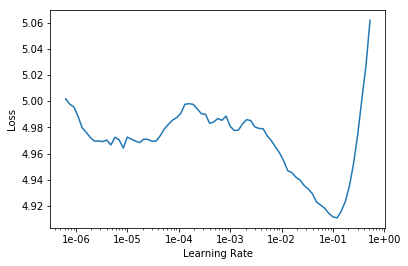

In [44]:
learn.recorder.plot(skip_end=15)

In [45]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.306537,4.134293,0.286484,28:40


In [46]:
learn.save('fit_head_v5.0.0')

In [47]:
learn.load('fit_head_v5.0.0')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (91871 items)
x: LMTextList
xxbos i did n't see this movie when it originally came out , but there has been a couple songs sharing the title and the term still gets used from time to time and i figured there must be something to the flick , so i dug it up and gave a view . xxmaj now i would like the approximate hour and forty five minutes of my life xxunk seemed much longer ) . xxmaj there was nothing particularly bad about the movie , the acting was good , no large plot holes , of course there was n't much plot to have holes in . xxmaj there just was n't a lot to the movie . xxmaj there was some chemistry between the two but nothing compelling about their relationship ; xxmaj nothing interesting about their story . xxmaj near the end when he attempts to chase down the train to catch his fleeing romance , neither my wife nor i wanted him to catch her . xxmaj honestly we figured they were better off with out each other and if they 

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


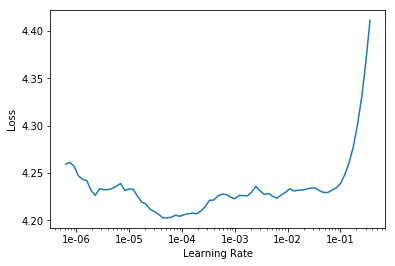

In [12]:
learn.recorder.plot(skip_end=15)

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [48]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.004263,3.961013,0.305101,32:08
1,3.901208,3.870895,0.316508,32:14
2,3.753442,3.842924,0.319894,32:14


In [50]:
learn.save('fine_tuned_v5.0.3')

In [7]:
learn.load('fine_tuned_v5.0.3')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (91871 items)
x: LMTextList
xxbos i did n't see this movie when it originally came out , but there has been a couple songs sharing the title and the term still gets used from time to time and i figured there must be something to the flick , so i dug it up and gave a view . xxmaj now i would like the approximate hour and forty five minutes of my life xxunk seemed much longer ) . xxmaj there was nothing particularly bad about the movie , the acting was good , no large plot holes , of course there was n't much plot to have holes in . xxmaj there just was n't a lot to the movie . xxmaj there was some chemistry between the two but nothing compelling about their relationship ; xxmaj nothing interesting about their story . xxmaj near the end when he attempts to chase down the train to catch his fleeing romance , neither my wife nor i wanted him to catch her . xxmaj honestly we figured they were better off with out each other and if they 

In [8]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.771381,3.844455,0.319763,28:38
1,3.722141,3.839503,0.320459,28:43


In [9]:
learn.save('fine_tuned_v5.0.5')

In [10]:
learn.load('fine_tuned_v5.0.5')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (91871 items)
x: LMTextList
xxbos i did n't see this movie when it originally came out , but there has been a couple songs sharing the title and the term still gets used from time to time and i figured there must be something to the flick , so i dug it up and gave a view . xxmaj now i would like the approximate hour and forty five minutes of my life xxunk seemed much longer ) . xxmaj there was nothing particularly bad about the movie , the acting was good , no large plot holes , of course there was n't much plot to have holes in . xxmaj there just was n't a lot to the movie . xxmaj there was some chemistry between the two but nothing compelling about their relationship ; xxmaj nothing interesting about their story . xxmaj near the end when he attempts to chase down the train to catch his fleeing romance , neither my wife nor i wanted him to catch her . xxmaj honestly we figured they were better off with out each other and if they 

In [11]:
learn.fit_one_cycle(2, 5e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.739649,3.838952,0.320460,28:43
1,3.712712,3.837298,0.320639,28:47


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
learn.save('fine_tuned_v5.0.7')

In [14]:
learn.load('fine_tuned_v5.0.7')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (91871 items)
x: LMTextList
xxbos i did n't see this movie when it originally came out , but there has been a couple songs sharing the title and the term still gets used from time to time and i figured there must be something to the flick , so i dug it up and gave a view . xxmaj now i would like the approximate hour and forty five minutes of my life xxunk seemed much longer ) . xxmaj there was nothing particularly bad about the movie , the acting was good , no large plot holes , of course there was n't much plot to have holes in . xxmaj there just was n't a lot to the movie . xxmaj there was some chemistry between the two but nothing compelling about their relationship ; xxmaj nothing interesting about their story . xxmaj near the end when he attempts to chase down the train to catch his fleeing romance , neither my wife nor i wanted him to catch her . xxmaj honestly we figured they were better off with out each other and if they 

How good is our model? Well let's try to see what it predicts after a few given words.

In [15]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [16]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it had some of the most original screenplay writing i 've ever been up to . It 's based on a true story ; it 's about the Irish Civil War . The English
I liked this movie because it reminded me of a TV movie in my opinion . As a kid , Nickelodeon was a great show , and i like how they have an original story line , and i was disappointed when


We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [19]:
learn.save_encoder('fine_tuned_enc_v5.0.7')

## 3. Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [7]:
bs=48

In [10]:
# Once unfreeze last 3 layer, batch 48 icause CUDA to run out of memory.
bs = 24

In [6]:
# Once unfreeze all layers, batch 24 cause CUDA to run out of memory.
bs = 16

In [11]:
path = Config.data_path()/'solvay'

In [146]:
data_clas = (TextList.from_csv(path, 'training_set_26-2-2019.csv', cols='text', vocab=data_lm.vocab)
             #grab all the text files in csv
             .split_from_df(col='is_valid')
              #How to split it?
             .label_from_df(cols='score_01')
              #Label it from dataframe
             # .add_test(TextList.from_csv(path, 'test_set_no_score_26-2-2019.csv', cols='text', vocab=data_lm.vocab))
             # add test
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [147]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [93]:
data_clas.show_batch()

text,target
"xxbos xxmaj there 's a sign on xxmaj the xxmaj lost xxmaj highway that xxunk xxup spoilers xxunk you already knew that , did n't xxunk there 's a great deal of people that apparently did not get the point of this movie , i 'd like to contribute my interpretation of why the plot makes perfect sense . xxmaj as others have pointed out , one single viewing of",1
"xxbos xxmaj it 's always difficult to put a stamp on any film as being ' the best , ' whether of all time , a certain genre , or what have you , but i believe a strong argument could be made that in fact , xxmaj laputa is the greatest animated film ever made . xxmaj it is in my mind the masterwork of xxmaj hayao xxmaj miyazaki",1
xxbos xxmaj the xxmaj concorde ... xxmaj airport ' 79 starts in xxmaj washington where a man named xxmaj carl xxmaj parker ( xxmaj macon ( mccalman ) contacts high profile xxup tv news reporter xxmaj maggie xxmaj whelan ( xxmaj susan xxmaj blakely ) in order to hand secret documents over that prove his boss xxmaj kevin xxmaj xxunk ( xxmaj robert xxmaj wagner ) owner & president of,0
"xxbos i would probably not have bothered to comment on this film if i had not been disturbed by the constant references made to it here in xxmaj north xxmaj america as a porn film . xxmaj our obsession with what is , or should be , regarded as pornographic remains a relic of the ' guidance ' provided to film makers by the xxmaj hayes committee many , many",1
"xxbos xxmaj kubrick meets xxmaj king . xxmaj it sounded so promising back in the spring of 1980 , i remember . xxmaj then the movie came out , and the xxmaj kubrick cultists have been bickering with the xxmaj king cultists ever since . xxmaj the xxmaj king cultists say xxmaj stanley xxmaj kubrick took a great horror tale and ruined it . xxmaj the xxmaj kubrick cultists do",0


We can then create a model to classify those reviews and load the encoder we saved before.

In [148]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc_v5.0.7')

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


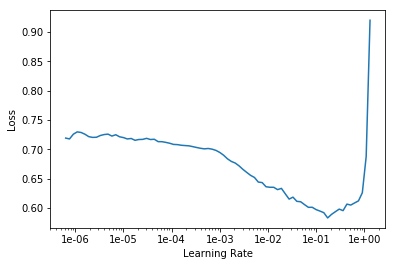

In [12]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.363742,0.310182,0.869720,09:09


In [14]:
learn.save('first_v5.1.0')

In [15]:
learn.load('first_v5.1.0')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (68560 items)
x: TextList
xxbos xxmaj some decent stuff , but he barely mentions xxunk , which are becoming a bigger piece of the asset puzzle .,xxbos xxmaj this movie is so bad that it actually gets funny . xxmaj one of the worst movies i 've ever seen in my entire life . xxmaj the funny thing was that the trailer had scenes in it that was n't in the movie . xxmaj just by watching the trailer i would have saved a lot of my time . xxmaj it actually showed everything that happened in the movie except for the conclusion and that was also so obvious . xxmaj it 's honestly hard to think of a reason why this movie was made . xxmaj this is just so bad . xxmaj horrible . i would give it 0 out of 10 if that would be possible . xxmaj there is nothing else to say about this movie .,xxbos xxmaj this book by xxmaj dave xxmaj pelzer was by far the best book i have read . xxmaj he mixed great wording and tear - jerking events to keep the reader fl

In [14]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3e-3/(2.6**4),3e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.226457,0.239210,0.902800,10:06


In [15]:
learn.save('second_v5.1.1')

In [13]:
learn.load('second_v5.1.1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (68560 items)
x: TextList
xxbos xxmaj some decent stuff , but he barely mentions xxunk , which are becoming a bigger piece of the asset puzzle .,xxbos xxmaj this movie is so bad that it actually gets funny . xxmaj one of the worst movies i 've ever seen in my entire life . xxmaj the funny thing was that the trailer had scenes in it that was n't in the movie . xxmaj just by watching the trailer i would have saved a lot of my time . xxmaj it actually showed everything that happened in the movie except for the conclusion and that was also so obvious . xxmaj it 's honestly hard to think of a reason why this movie was made . xxmaj this is just so bad . xxmaj horrible . i would give it 0 out of 10 if that would be possible . xxmaj there is nothing else to say about this movie .,xxbos xxmaj this book by xxmaj dave xxmaj pelzer was by far the best book i have read . xxmaj he mixed great wording and tear - jerking events to keep the reader fl

In [21]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.213927,0.234154,0.907351,19:15


In [23]:
learn.save('third_v5.1.3')

In [9]:
learn.load('third_v5.1.3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (68560 items)
x: TextList
xxbos xxmaj some decent stuff , but he barely mentions xxunk , which are becoming a bigger piece of the asset puzzle .,xxbos xxmaj this movie is so bad that it actually gets funny . xxmaj one of the worst movies i 've ever seen in my entire life . xxmaj the funny thing was that the trailer had scenes in it that was n't in the movie . xxmaj just by watching the trailer i would have saved a lot of my time . xxmaj it actually showed everything that happened in the movie except for the conclusion and that was also so obvious . xxmaj it 's honestly hard to think of a reason why this movie was made . xxmaj this is just so bad . xxmaj horrible . i would give it 0 out of 10 if that would be possible . xxmaj there is nothing else to say about this movie .,xxbos xxmaj this book by xxmaj dave xxmaj pelzer was by far the best book i have read . xxmaj he mixed great wording and tear - jerking events to keep the reader fl

In [15]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.227050,0.227916,0.909977,52:45


In [16]:
learn.save('unfreeze_v5.1.5')

In [8]:
learn.load('unfreeze_v5.1.5')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (68560 items)
x: TextList
xxbos xxmaj some decent stuff , but he barely mentions xxunk , which are becoming a bigger piece of the asset puzzle .,xxbos xxmaj this movie is so bad that it actually gets funny . xxmaj one of the worst movies i 've ever seen in my entire life . xxmaj the funny thing was that the trailer had scenes in it that was n't in the movie . xxmaj just by watching the trailer i would have saved a lot of my time . xxmaj it actually showed everything that happened in the movie except for the conclusion and that was also so obvious . xxmaj it 's honestly hard to think of a reason why this movie was made . xxmaj this is just so bad . xxmaj horrible . i would give it 0 out of 10 if that would be possible . xxmaj there is nothing else to say about this movie .,xxbos xxmaj this book by xxmaj dave xxmaj pelzer was by far the best book i have read . xxmaj he mixed great wording and tear - jerking events to keep the reader fl

In [ ]:
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

In [ ]:
learn.save('unfreeze_v5.0.7.2')

In [ ]:
learn.load('unfreeze_v5.0.7.2')

In [5]:
## learn.fit_one_cycle(5,1e-4, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='model')])
## callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='model')]

In [138]:
# Check how the model behaves on new data
learn.predict("I really loved that movie, it was awesome!")

(Category 1, tensor(1), tensor([2.8856e-04, 9.9971e-01]))

## 4. Running the Model on Test set



In [149]:
learn.load('unfreeze_v5.1.3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (68560 items)
x: TextList
xxbos xxmaj some decent stuff , but he barely mentions xxunk , which are becoming a bigger piece of the asset puzzle .,xxbos xxmaj this movie is so bad that it actually gets funny . xxmaj one of the worst movies i 've ever seen in my entire life . xxmaj the funny thing was that the trailer had scenes in it that was n't in the movie . xxmaj just by watching the trailer i would have saved a lot of my time . xxmaj it actually showed everything that happened in the movie except for the conclusion and that was also so obvious . xxmaj it 's honestly hard to think of a reason why this movie was made . xxmaj this is just so bad . xxmaj horrible . i would give it 0 out of 10 if that would be possible . xxmaj there is nothing else to say about this movie .,xxbos xxmaj this book by xxmaj dave xxmaj pelzer was by far the best book i have read . xxmaj he mixed great wording and tear - jerking events to keep the reader fl

In [151]:
# add the data set to the learner object
learn.data.add_test(TextList.from_csv(path, 'test_set_no_score_26-2-2019.csv', cols='text', vocab=data_lm.vocab))

In [152]:
# Order must be true since predictions must match the id in the dataframe 
pred_test = learn.get_preds(ds_type=DatasetType.Test, ordered=True)

In [153]:
test_result = torch.argmax(pred_test[0], dim=1)

In [154]:
result = test_result.numpy()

In [189]:
# to test directly on the data frame's text
# learn.predict(df_test['text'][36])

In [191]:
df_test = pd.read_csv(path/'test_set_no_score_26-2-2019.csv')

In [193]:
# append the array of prediction
df_test['score_01'] = result

In [202]:
# Examine through some example to chack the model's prediction
df_test

,_id,text,score_01
0,5c6d03c268869913683e7e1a,I really prefer the Shoumei Green Tea which is...,0
1,5c6d03c268869913683e7e4c,"I have liked other Hot Pockets, like the ham a...",0
2,5c6d03c268869913683e7e50,This carafe was initially perfect. The design...,0
3,5c6d03c268869913683e7e62,I bought this to give my love life some spice....,0
4,5c6d03c268869913683e7e89,"This milk is advertised as ""vanilla"" milk. But...",0
5,5c6d03c268869913683e7eb5,The coffee came in a timely manner and is quit...,1
6,5c6d03c268869913683e7fba,These steaks were tender and tasted very good....,1
7,5c6d03c268869913683e800b,"Lindt Lindor truffles are very smooth, quite r...",1
8,5c6d03c268869913683e8018,I gave 3 sets of popcorn along with the bowls ...,1
9,5c6d03c268869913683e801f,****,1


In [194]:
# df_test = df_test.drop['text']

,_id,text,score_01
0,5c6d03c268869913683e7e1a,I really prefer the Shoumei Green Tea which is...,0
1,5c6d03c268869913683e7e4c,"I have liked other Hot Pockets, like the ham a...",0
2,5c6d03c268869913683e7e50,This carafe was initially perfect. The design...,0
3,5c6d03c268869913683e7e62,I bought this to give my love life some spice....,0
4,5c6d03c268869913683e7e89,"This milk is advertised as ""vanilla"" milk. But...",0
5,5c6d03c268869913683e7eb5,The coffee came in a timely manner and is quit...,1
6,5c6d03c268869913683e7fba,These steaks were tender and tasted very good....,1
7,5c6d03c268869913683e800b,"Lindt Lindor truffles are very smooth, quite r...",1
8,5c6d03c268869913683e8018,I gave 3 sets of popcorn along with the bowls ...,1
9,5c6d03c268869913683e801f,****,1


Keeping the score of models:https://docs.google.com/spreadsheets/d/1VmECIR5xnYNL7Cjs458-ylUXlMRLhuLHv78muaTR9yE/edit?usp=sharing

In [204]:
learn.export('FastAi_model.pkl')

In [203]:
df_test.to_json(path/'FastAi_results_with_text.json', orient='records')

In [4]:
df_test = pd.read_json(path/'FastAi_results_with_text.json')

In [17]:
df_test = df_test.drop(['text'], axis=1)

In [18]:
df_test.to_json(path/'FastAi_results_tosubmit.json', orient='records')